# TP 2-3 : Branch-and-bound applied to a knapsack problem

## Léo Meissner Lisa Weisbecker

### Questions préliminaires

1. La règle de séparation est de diviser le premier objet dans la liste qui n'a pas encore été fixé.

2. Ici la borne supérieur est directement la fonction objectif que l'on test dans le noeud. Le programme résout la relaxation linéaire du problème.

3. Les tests de sondabilité sont les mêmes que les ceux utilisés en TD :

* Le test d'admissibilité réussi lorsque la capacité restante est négative.

* Le test d'optimalité réussi si la fonction objectif que l'on vient de calculer est pire que la meilleure solution connue du problème.

* Le test de résolution réussi s'il ne reste plus qu'une variable/objet du sac a fixée.

4. La stratégie d'exploration est la suivante : Le noeud où la variable est fixé à 1 par la règle de séparation est exploré jusqu'à ce qu'il soit sondable, une fois le noeud sondé on retourne au noeud supérieur pour explorer le noeud où la variable est fixé à 0. La stratégie est réitérée jusqu'à ce qu'il n'y ait plus aucun noeud à exploré.

### Initialisation (à faire une seule fois)

In [1]:
import Pkg; 
Pkg.add("GraphRecipes"); Pkg.add("Plots"); 
using GraphRecipes, Plots #only used to visualize the search tree at the end of the branch-and-bound

    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


### Récupération des données

In [2]:
function readKnaptxtInstance(filename)
    price=[]
    weight=[]
    KnapCap=[]
    open(filename) do f
        for i in 1:3
            tok = split(readline(f))
            if(tok[1] == "ListPrices=")
                for i in 2:(length(tok)-1)
                    push!(price,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "ListWeights=")
                for i in 2:(length(tok)-1)
                    push!(weight,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "Capacity=")
                push!(KnapCap, parse(Int64, tok[2]))
            else
                println("Unknown read :", tok)
            end 
        end
    end
    capacity=KnapCap[1]
    return price, weight, capacity
end

readKnaptxtInstance (generic function with 1 method)

### Tests de sondabilités TA, TO et TR basés sur le modèle linéaire

In [3]:
function TestsSondabilite_LP(model2, BestProfit, Bestsol)
    TA, TO, TR = false, false, false
    if(model2.infeasible)#Test d'admissibilité
        TA=true
        println("TA")
        
    elseif(model2.bound <= BestProfit) #Test d'optimalite
        TO=true
        println("TO")
    elseif(verifTR(model2)) #Test de resolution
        TR=true
        println("TR")
        #if (value(benef) >= BestProfit)
        currentProfit = currentPrice(model2)
        if (currentProfit >= BestProfit) #If the current profit is better than the best known, it is replaced
            Bestsol = model2.variables       
            #BestProfit=value(benef)
            BestProfit= currentProfit
            println("\nNew Solution memorized ", Bestsol, " with bestprofit ", BestProfit, "\n")
        end
    else
        println("non sondable")
    end
    TA, TO, TR, Bestsol, BestProfit
end

TestsSondabilite_LP (generic function with 1 method)

Les tests de sondabilités sont basés sur les bornes supérieures.

* Le test d'admissibilité réussi lorsque la capacité restante est négative. Infeasible est un booleen qui devient faux lorsque la capacité du sac est négative.

* Le test d'optimalité réussi si la borne supérieur que l'on vient de calculer est pire que la meilleure solution connue du problème.

* Le test de résolution réussi s'il ne reste plus qu'une variable/objet du sac a fixée. A ce moment là soit la capacité du sac est suffisante et on ajoute l'objet, soit l'objet ne rentre pas et on ne l'ajoute pas. C'est le rôle de la fonction vérifTR

## Procédure de séparation (branching) et stratégie d'exploration permettant de se placer au prochain noeud à traiter

In [4]:

function SeparerNoeud_lexicographic_depthfirst!(model2, listobjs, listvals, n)
    # this node is non-sondable. Apply the branching criterion to separate it into two subnodes
    # and choose the child-node at the left  
    
    # lexicographic branching criterion: branch on the 1st object not yet fixed
    bestObj = objDecision(0.0, 0.0,0.0, 0.0,  0.0, false) #  Unlocked object that will have the best ratio after the loop
        for obj in model2.variables
            if obj.ratio > bestObj.ratio && !obj.lock
                bestObj = obj
            end
        end
        lockObj(model2, bestObj, 1.0)
    


    println("\nbranch on object ", bestObj, "\n")
    #Ajout de fonctionnalités
    # depthfirst exploration strategy: the node selected will be the most left of the child-nodes just created
    push!(listobjs,bestObj) #save the identity of the object selected for branching
    push!(listvals,1.0) #save the node selected, identified by the value assigned to the variable/object chosen
    return listobjs, listvals
end 


function ExplorerAutreNoeud_depthfirst!(model2, listobjs, listvals, listnodes)
    #this node is sondable, go back to parent node then right child if possible
    
    stop=false
    #check if we are not at the root node
    if (length(listobjs)>= 1)
        #go back to parent node
        obj=pop!(listobjs)
        theval=pop!(listvals)
        tmp=pop!(listnodes)
        unlockObj(model2, obj)

        #go to right child if possible, otherwise go back to parent
        while( (theval==0.0) && (length(listobjs)>= 1))
            obj=pop!(listobjs)
            theval=pop!(listvals)
            tmp=pop!(listnodes)
            unlockObj(model2, obj)
        end
        if theval==1.0
            lockObj(model2, obj, 0.0)
            push!(listobjs,obj)
            push!(listvals,0.0)
        else
            println("\nFINISHED")
            stop=true
        end
    else
        #the root node was sondable
        println("\nFINISHED")
        stop=true
    end
    return listobjs, listvals, listnodes, stop 
end

ExplorerAutreNoeud_depthfirst! (generic function with 1 method)

Dans notre algorithme pour le calcul de la borne 1, notre règle de séparation est de choisir la première variable qui n'a pas été fixée dans l'ordre décroissant du ratio. Cela crée alors les 2 sous problèmes suivant : $x_k = 0$ et $x_k = 1$

###  Création de la relaxation avec les règles simples vues en TD: 

In [5]:
mutable struct objDecision
    value::Float64
    price::Float64
    weight::Float64
    ratio::Float64
    index::Int64
    lock::Bool                  # Lock, the value is choosen, !Lock, the value is not choosen yet

end

mutable struct modelBase
    bound1_2::String             # Choice of the bound
    capacity::Int64
    variables::Array{objDecision, 1}
    bound::Float64
    nbFree::Int64                 # Number of values not locked
    infeasible::Bool
    
end

# Creation of the model from the choice of the bound, the price and weight of the objects and the capacity of the bag
function CreationModele_LP(boundChoice, price,weight, capacity)
    n = length(price)
    variables = Array{objDecision, 1}(undef, n)
    for i = 1:n
        variables[i] = objDecision(0.0, price[i], weight[i], price[i]/weight[i],  i, false)
    end

    return model2 = modelBase(boundChoice, capacity, variables , -1, n, false)
end

# Calculation of the current price contained in the bag
function currentPrice(model)
    return sum([obj.value * obj.price for obj in model.variables])
end

#Calculation of the actual weight in the bag
function currentWeight(model)
    sum([obj.value*obj.weight for obj in model.variables])
end

# Unlocking an object when going backwards in the tree
function unlockObj(model, obj)
    model.nbFree += 1 #Increment the number of variables still free in the problem
    obj.lock = false
end

# Locking an object when choosing its value
function lockObj(model, obj, value)
    obj.lock = true
    obj.value = value
    model.nbFree -= 1 # We decrement the number of variables still free in the problem
end

# Verification function of the resolution test explained above
function verifTR(model)
    if (model.nbFree == 1) 
            i, index = 1, 0
            while((i<= length(model.variables)) && (index ==0))
                obj = model.variables[i]
                if !obj.lock   #Search for the object that is not locked
                    index=i
                    remainingCapacity = model.capacity - currentWeight(model)
                    if obj.weight <= remainingCapacity # Inclusion in the bag if the remaining weight allows it
                        obj.value = 1.0
                    else
                        obj.value = 0.0
                    end
                end
                i += 1
            end

    end
    return (model.nbFree == 1)
end

#Function that calculates the upper bound of a node
function calculUpperBound(model)
    remainingCapacity = model.capacity - currentWeight(model)
    infeasible = remainingCapacity < 0
    bound = -1
    if !infeasible
        if model.bound1_2 == "bound1" #Calculation of the first bound
            # Calculation of the current price in the bag
            bound = currentPrice(model)
            bestObj = objDecision(0.0, 0.0,0.0, 0.0,  0.0, false)  # Unlocked object with the best ratio after the loop
            for obj in model.variables
                if obj.ratio > bestObj.ratio && !obj.lock
                    bestObj = obj
                end
            end
            bound += remainingCapacity * bestObj.ratio # Upper bound calucl
        elseif model.bound1_2 == "bound2" # Calculation of the second bound
            bound = currentPrice(model)
            for i in model.variables
                if remainingCapacity < 0
                    break
                end

                bestObj = objDecision(0.0, 0.0,0.0, 0.0,  0.0, false)  # Unlocked object with the best ratio after the for loop
                for obj in model.variables
                    if obj.ratio > bestObj.ratio && !obj.lock
                        bestObj = obj
                    end
                end
                if bestObj.weight <= remainingCapacity
                    bestObj.value = 1.0
                    remainingCapacity = remainingCapacity - bestObj.weight 
                else
                    bestObj.value = remainingCapacity / bestObj.weight
                    remainingCapacity = 0.0
                end

            end

        end
    end
    model.infeasible = infeasible
    model.bound = bound
end



calculUpperBound (generic function with 1 method)

### Boucle principale : résoudre une relaxation, appliquer les tests de sondabilité, identifier le prochain noeud, répéter.

In [6]:

function SolveKnapInstance(filename)

    price, weight, capacity = readKnaptxtInstance(filename)

    model2 = CreationModele_LP("bound1", price, weight, capacity) ############################## Put bound2 instead of bound1 to have the second bound calculation
    #create the structure to memorize the search tree for visualization at the end
    trParentnodes=Int64[] #will store orig node of arc in search tree
    trChildnodes=Int64[] #will store destination node of arc in search tree
    trNamenodes=[] #will store names of nodes in search tree

    #intermediate structure to navigate in the search tree
    listobjs=[]
    listvals=[]
    listnodes=[]

    BestProfit=-1
    Bestsol=Array{objDecision, 1}(undef, length(price))

    current_node_number=0
    stop = false

    while(!stop)

        println("\nNode number ", current_node_number, ": \n---------------\n")

        #Update the graphical tree
        push!(trNamenodes,current_node_number+1) 
        if(length(trNamenodes)>=2)
            push!(trParentnodes,listnodes[end]+1) # +1 because the 1st node is "node 0"
            push!(trChildnodes, current_node_number+1) # +1 because the 1st node is "node 0"
        end
        push!(listnodes, current_node_number)

        
        #create LP of current node
        calculUpperBound(model2)
        
    
        
        #print("Solve the LP model of the current node to compute its bound: start ... ")
        #status = optimize!(model2)
        #println("... end"); 

        print(": Solution LP")
        if(model2.infeasible)#(has_values(model2))
            print(" : NOT AVAILABLE (probably infeasible or ressources limit reached)")
        else
            print(" ", currentPrice(model2))
            [print("\t", v.price,"=",v.value) for v in model2.variables] 
        end
        println(" "); 


        println("\nPrevious Solution memorized ", Bestsol, " with bestprofit ", BestProfit, "\n")

        TA, TO, TR, Bestsol, BestProfit = TestsSondabilite_LP(model2, BestProfit, Bestsol)

        is_node_sondable = TA || TO || TR

        #Reset_LP!(model2, x, listobjs)

        if(!is_node_sondable)
            listobjs, listvals = SeparerNoeud_lexicographic_depthfirst!(model2, listobjs, listvals, length(price))
        else
            listobjs, listvals, listnodes, stop = ExplorerAutreNoeud_depthfirst!(model2, listobjs, listvals, listnodes)
        end

        current_node_number = current_node_number + 1
    end

    println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)

    return BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes

end


SolveKnapInstance (generic function with 1 method)

### Affichage du résultat final


Node number 0: 
---------------

: Solution LP 0.0	42.0=0.0	40.0=0.0	12.0=0.0	25.0=0.0	24.0=0.0	32.0=0.0 

Previous Solution memorized 

objDecision[#undef, #undef, #undef, #undef, #undef, #undef] with bestprofit -1

non sondable

branch on object 

objDecision(1.0, 40.0, 4.0, 10.0, 2, true)


Node number 1: 
---------------

: Solution LP 40.0	42.0=0.0	40.0=1.0	12.0=0.0	25.0=0.0	24.0=0.0	32.0=0.0 

Previous Solution memorized objDecision[#undef, #undef, #undef, #undef, #undef, #undef] with bestprofit -1

non sondable

branch on object objDecision(1.0, 42.0, 7.0, 6.0, 1, true)


Node number 2: 
---------------

: Solution LP 82.0	42.0=1.0	40.0=1.0	12.0=0.0	25.0=0.0	24.0=0.0	32.0=0.0 

Previous Solution memorized objDecision[#undef, #undef, #undef, #undef, #undef, #undef] with bestprofit -1

non sondable

branch on object objDecision(1.0, 32.0, 6.0, 5.333333333333333, 6, true)


Node number 3: 
---------------

: Solution LP 114.0	42.0=1.0	40.0=1.0	12.0=0.0	25.0=0.0	24.0=0.0	32.0=1.0 

Previous Solution memorized objDecision[#undef, #undef, #undef, #undef, #undef, #undef] with bestprofit -1

non sondable

branch on object objDecision(1.0, 25.0, 5.0, 5.0, 4, true)


Node number 4: 
---------------

: Solution LP : NOT AVAILABLE (pro

objDecision(1.0, 42.0, 7.0, 6.0, 1, true), objDecision(1.0, 40.0, 4.0, 10.0, 2, true), objDecision(1.0, 12.0, 3.0, 4.0, 3, true), objDecision(0.0, 25.0, 5.0, 5.0, 4, true), objDecision(0.0, 24.0, 9.0, 2.6666666666666665, 5, false), objDecision(1.0, 32.0, 6.0, 5.333333333333333, 6, true)] with bestprofit 126.0


Node number 7: 
---------------

: Solution LP 114.0	42.0=1.0	40.0=1.0	12.0=0.0	25.0=0.0	24.0=0.0	32.0=1.0 

Previous Solution memorized objDecision[objDecision(1.0, 42.0, 7.0, 6.0, 1, true), objDecision(1.0, 40.0, 4.0, 10.0, 2, true), objDecision(0.0, 12.0, 3.0, 4.0, 3, true), objDecision(0.0, 25.0, 5.0, 5.0, 4, true), objDecision(0.0, 24.0, 9.0, 2.6666666666666665, 5, false), objDecision(1.0, 32.0, 6.0, 5.333333333333333, 6, true)] with bestprofit 126.0

TO

Node number 8: 
---------------

: Solution LP 82.0	42.0=1.0	40.0=1.0	12.0=0.0	25.0=0.0	24.0=0.0	32.0=0.0 

Previous Solution memorized objDecision[objDecision(1.0, 42.0, 7.0, 6.0, 1, true), objDecision(1.0, 40.0, 4.0, 10.

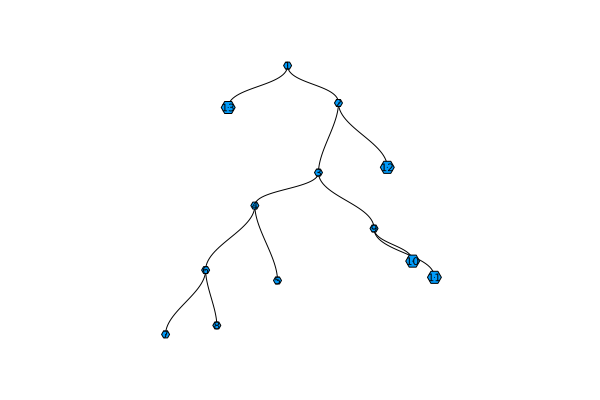

In [7]:
BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes = SolveKnapInstance("instancesETU/KNAPnewformat/test.opb.txt")
println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)
graphplot(trParentnodes, trChildnodes, names=trNamenodes, method=:tree)

Question 5 : Le calcul de la borne 1 fonctionne bien et a été avec plusieurs tailles et instances différentes. Nous avons ajouté le calcul de la borne 2 comme il devrait être réalisé mais nous ne somme pas parvenu à implémenter la partie relative à l'exploration et la séparation des noeuds pour la borne 2 ce qui fait que les choix de valeurs ne sont pas vérouiller immédiatement. Nous pensons donc que des améliorations restent possibles. Nous remarquons tout de même que le nombre de noeuds diminue lorsque l'on augmente le nombre d'objets à mettre dans le sac ainsi que la capacité. Par exemple pour les valeurs enregistrés ici, nous avons 13 noeuds pour la borne 1 alors qu'il y en uniquement 11 noeuds pour la borne 2, avec la même valeur optimale trouvé par les 2 bornes. Par contre si la capacité est faible, les 2 bornes jouent le même rôle donc pas de différence à ce niveau là.

Ce résultat semble cohérent car le calcul de la borne numéro 2 est plus fin que celui de la borne 1. Le test d'optimalité entrera donc plus rapidement en jeu afin d'éliminer les noeuds inutiles.